In [1]:
# Some imports to get us started
# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

/Users/raphaeltamaki/Documents/personal_git/causal_venv/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/raphaeltamaki/Documents/personal_git/causal_venv/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-

In [2]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [3]:
# Data sample
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [5]:
# Define estimator inputs
Y = train_data["demand"]  # outcome of interest
T = train_data["price"]  # intervention, or treatment
X = train_data[["income"]]  # features
W = train_data.drop(columns=["demand", "price", "income"])  # confounders

In [6]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
# X_test_data = pd.DataFrame(np.linspace(0, 5, 100), columns=["income"])
X_test_data = pd.DataFrame(X_test, columns=["income"])

In [7]:
# Define underlying treatment effect function given DGP
def gamma_fn(X):
    return -3 - 14 * (X["income"] < 1)

def beta_fn(X):
    return 20 + 0.5 * (X["avg_hours"]) + 5 * (X["days_visited"] > 4)

def demand_fn(data, T):
    Y = gamma_fn(data) * T + beta_fn(data)
    return Y

def true_te(x, n, stats):
    if x < 1:
        subdata = train_data[train_data["income"] < 1].sample(n=n, replace=True)
    else:
        subdata = train_data[train_data["income"] >= 1].sample(n=n, replace=True)
    te_array = subdata["price"] * gamma_fn(subdata) / (subdata["demand"])
    if stats == "mean":
        return np.mean(te_array)
    elif stats == "median":
        return np.median(te_array)
    elif isinstance(stats, int):
        return np.percentile(te_array, stats)

In [8]:
# Get the estimate and range of true treatment effect
truth_te_estimate = np.apply_along_axis(true_te, 1, X_test, 1000, "mean")  # estimate
truth_te_upper = np.apply_along_axis(true_te, 1, X_test, 1000, 95)  # upper level
truth_te_lower = np.apply_along_axis(true_te, 1, X_test, 1000, 5)  # lower level

In [9]:
# Get log_T and log_Y
log_T = np.log(T)
log_Y = np.log(Y)

In [10]:
?LinearDML

Init signature:
LinearDML(
    *,
    model_y='auto',
    model_t='auto',
    featurizer=None,
    treatment_featurizer=None,
    fit_cate_intercept=True,
    linear_first_stages=True,
    discrete_treatment=False,
    categories='auto',
    cv=2,
    mc_iters=None,
    mc_agg='mean',
    random_state=None,
)
Docstring:     
The Double ML Estimator with a low-dimensional linear final stage implemented as a statsmodel regression.

Parameters
----------
model_y: estimator or 'auto', default 'auto'
    The estimator for fitting the response to the features. Must implement
    `fit` and `predict` methods.
    If 'auto' :class:`.WeightedLassoCV`/:class:`.WeightedMultiTaskLassoCV` will be chosen.

model_t: estimator or 'auto', default 'auto'
    The estimator for fitting the treatment to the features.
    If estimator, it must implement `fit` and `predict` methods;
    If 'auto', :class:`~sklearn.linear_model.LogisticRegressionCV` will be applied for discrete treatment,
    and :class:`.Weig

In [11]:
# Train EconML model
est = LinearDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingRegressor(),
    featurizer=PolynomialFeatures(degree=1, include_bias=False),
)
est.fit(log_Y, log_T, X=X, W=W, inference="statsmodels")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

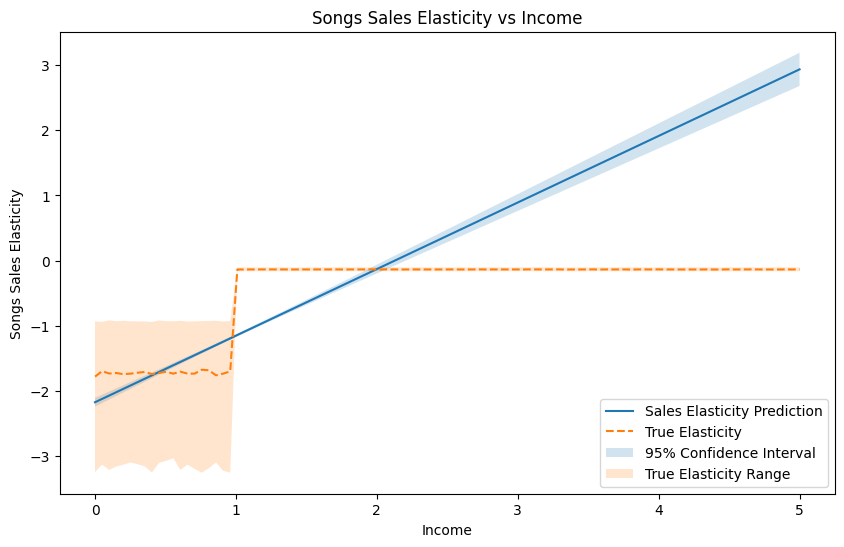

In [12]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

In [13]:
# Get the final coefficient and intercept summary
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
income,1.022,0.032,31.541,0.0,0.959,1.086
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-2.175,0.034,-63.354,0.0,-2.243,-2.108


## Nonparametric Heterogeneity

In [14]:
# Train EconML model
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor()
)
est.fit(log_Y, log_T, X=X, W=W, inference="blb")
# Get treatment effect and its confidence interval
te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

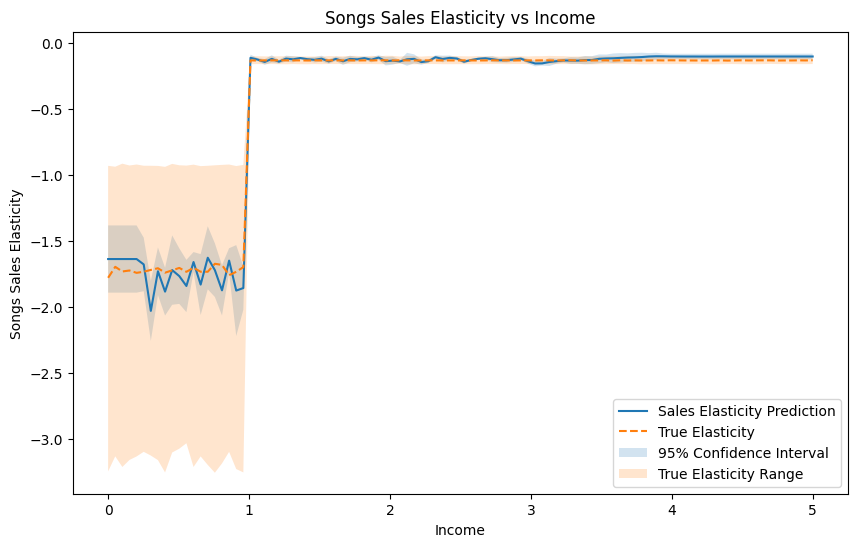

In [16]:
# Compare the estimate and the truth
plt.figure(figsize=(10, 6))
plt.plot(X_test.flatten(), te_pred, label="Sales Elasticity Prediction")
plt.plot(X_test.flatten(), truth_te_estimate, "--", label="True Elasticity")
plt.fill_between(
    X_test.flatten(),
    te_pred_interval[0],
    te_pred_interval[1],
    alpha=0.2,
    label="95% Confidence Interval",
)
plt.fill_between(
    X_test.flatten(),
    truth_te_lower,
    truth_te_upper,
    alpha=0.2,
    label="True Elasticity Range",
)
plt.xlabel("Income")
plt.ylabel("Songs Sales Elasticity")
plt.title("Songs Sales Elasticity vs Income")
plt.legend(loc="lower right")

## Understand Treatment Effects with EconML

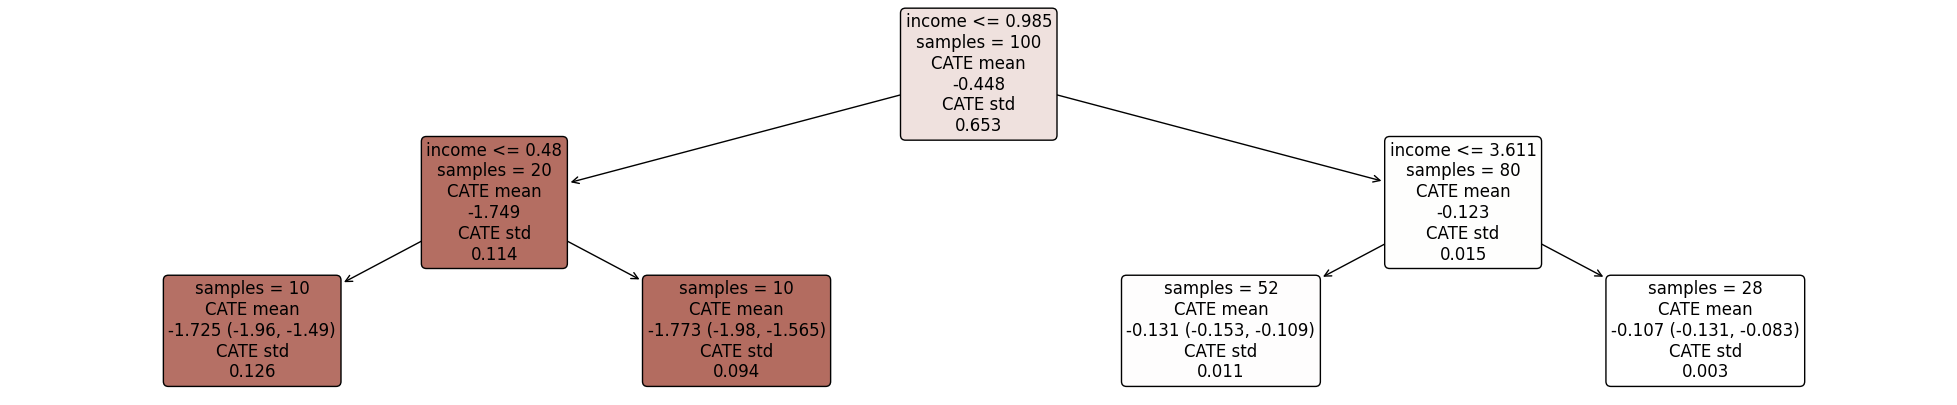

In [17]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est, X_test)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

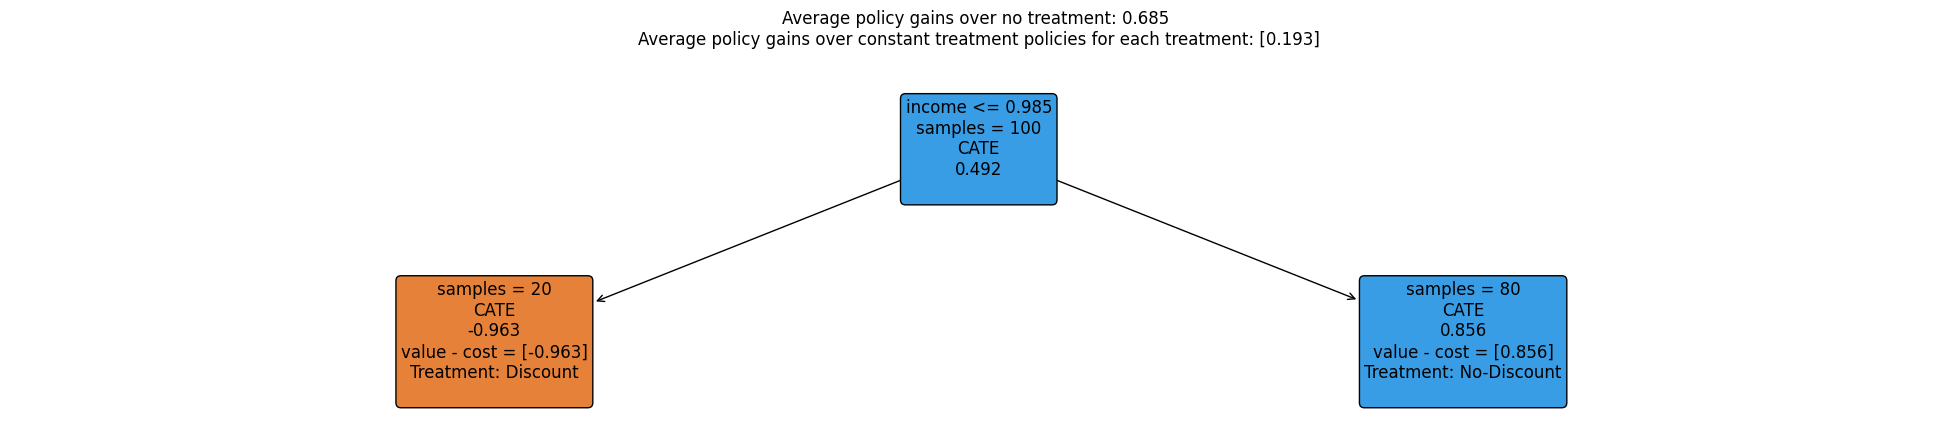

In [18]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, treatment_names=["Discount", "No-Discount"], fontsize=12)